In [ ]:
# ============================================
# 클러스터 시각화 (수정 버전)
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

print("=" * 60)
print("클러스터 시각화")
print("=" * 60)

# 데이터 로드
clustered_data = pd.read_csv('/content/drive/MyDrive/개인프로젝트 영상/데이터분석_머신러닝/data/HierachicalClustering_과제_data/clustered_data.csv')

print(f"\n📂 데이터 확인:")
print(f"   clustered_data 행 수: {len(clustered_data):,}")

# clustered_data에서 숫자형 컬럼만 추출 (클러스터링에 사용된 특성들)
# customer_unique_id, cluster 등 제외
exclude_cols = ['customer_unique_id', 'cluster', 'last_purchase_date', 'first_purchase_date',
                'payment_type_most_common', 'favorite_category', 'satisfaction_category']

# 실제 존재하는 제외 컬럼만 필터링
exclude_cols = [col for col in exclude_cols if col in clustered_data.columns]

# 숫자형 특성만 선택
numeric_features = clustered_data.select_dtypes(include=[np.number]).columns.tolist()

# cluster 컬럼 제외
if 'cluster' in numeric_features:
    numeric_features.remove('cluster')

print(f"   사용할 특성 수: {len(numeric_features)}개")
print(f"   클러스터 수: {clustered_data['cluster'].nunique()}개")

# 특성 데이터 추출
features_data = clustered_data[numeric_features].values

# 스케일링 (PCA는 스케일에 민감)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_data)

print(f"\n✅ 데이터 준비 완료!")
print(f"   데이터 형태: {features_scaled.shape}")

클러스터 시각화

📂 데이터 확인:
   clustered_data 행 수: 25,000
   사용할 특성 수: 27개
   클러스터 수: 7개

✅ 데이터 준비 완료!
   데이터 형태: (25000, 27)


In [ ]:
# --------------------------------------------
# 방법 1: PCA (주성분 분석)
# --------------------------------------------

print("\n" + "=" * 60)
print("방법 1: PCA (Principal Component Analysis)")
print("=" * 60)

# PCA로 2차원으로 축소
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)

# 설명된 분산 비율
print(f"\n📊 PCA 설명력:")
print(f"   PC1: {pca.explained_variance_ratio_[0]*100:.1f}%")
print(f"   PC2: {pca.explained_variance_ratio_[1]*100:.1f}%")
print(f"   Total: {sum(pca.explained_variance_ratio_)*100:.1f}%")

# DataFrame으로 변환 (이제 길이가 맞음!)
pca_df = pd.DataFrame({
    'PC1': pca_result[:, 0],
    'PC2': pca_result[:, 1],
    'cluster': clustered_data['cluster'].values
})

print(f"\n✅ PCA DataFrame 생성 완료: {pca_df.shape}")


방법 1: PCA (Principal Component Analysis)

📊 PCA 설명력:
   PC1: 23.4%
   PC2: 17.0%
   Total: 40.5%

✅ PCA DataFrame 생성 완료: (25000, 3)


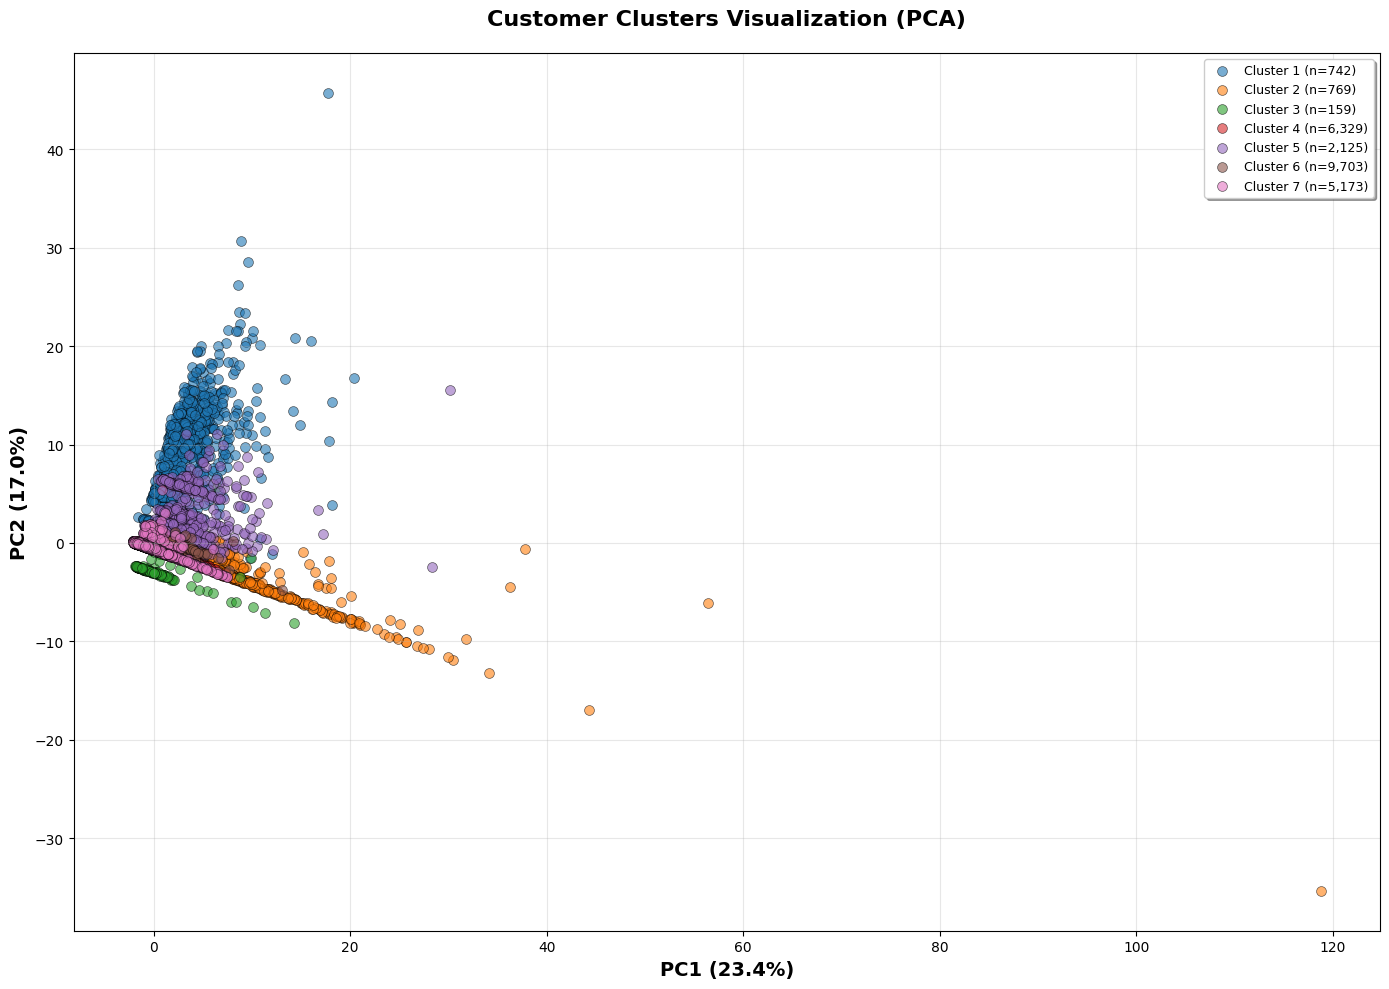


💡 PCA 해석:
   - 각 점 = 한 명의 고객
   - 색깔 = 클러스터
   - 가까이 있을수록 = 비슷한 고객


In [ ]:
# 시각화
plt.figure(figsize=(14, 10))

# 클러스터별 색상
clusters = sorted(pca_df['cluster'].unique())
colors = plt.cm.tab10(range(len(clusters)))

for idx, cluster_id in enumerate(clusters):
    cluster_data = pca_df[pca_df['cluster'] == cluster_id]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'],
                c=[colors[idx]],
                label=f'Cluster {cluster_id} (n={len(cluster_data):,})',
                alpha=0.6,
                s=50,
                edgecolors='black',
                linewidth=0.5)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=14, fontweight='bold')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=14, fontweight='bold')
plt.title('Customer Clusters Visualization (PCA)', fontsize=16, fontweight='bold', pad=20)
plt.legend(loc='best', fontsize=9, frameon=True, shadow=True)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 PCA 해석:")
print("   - 각 점 = 한 명의 고객")
print("   - 색깔 = 클러스터")
print("   - 가까이 있을수록 = 비슷한 고객")

In [ ]:
# --------------------------------------------
# 방법 2: t-SNE
# --------------------------------------------

print("\n" + "=" * 60)
print("방법 2: t-SNE (t-Distributed Stochastic Neighbor Embedding)")
print("=" * 60)

# 데이터가 너무 크면 샘플링
MAX_SAMPLES_FOR_TSNE = 5000

if len(features_scaled) > MAX_SAMPLES_FOR_TSNE:
    print(f"\n⚠️ t-SNE는 시간이 오래 걸려서 샘플링")
    print(f"   {len(features_scaled):,} → {MAX_SAMPLES_FOR_TSNE:,}")

    np.random.seed(42)
    sample_indices = np.random.choice(len(features_scaled), MAX_SAMPLES_FOR_TSNE, replace=False)
    tsne_data = features_scaled[sample_indices]
    tsne_clusters = clustered_data['cluster'].values[sample_indices]
else:
    tsne_data = features_scaled
    tsne_clusters = clustered_data['cluster'].values

print("\n🔄 t-SNE 계산 중... (1-2분 소요)")

# t-SNE 적용
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, verbose=1)
tsne_result = tsne.fit_transform(tsne_data)

print("✅ t-SNE 계산 완료!")


방법 2: t-SNE (t-Distributed Stochastic Neighbor Embedding)

⚠️ t-SNE는 시간이 오래 걸려서 샘플링
   25,000 → 5,000

🔄 t-SNE 계산 중... (1-2분 소요)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 0.948s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.518464
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.874084
[t-SNE] KL divergence after 1000 iterations: 0.934494
✅ t-SNE 계산 완료!


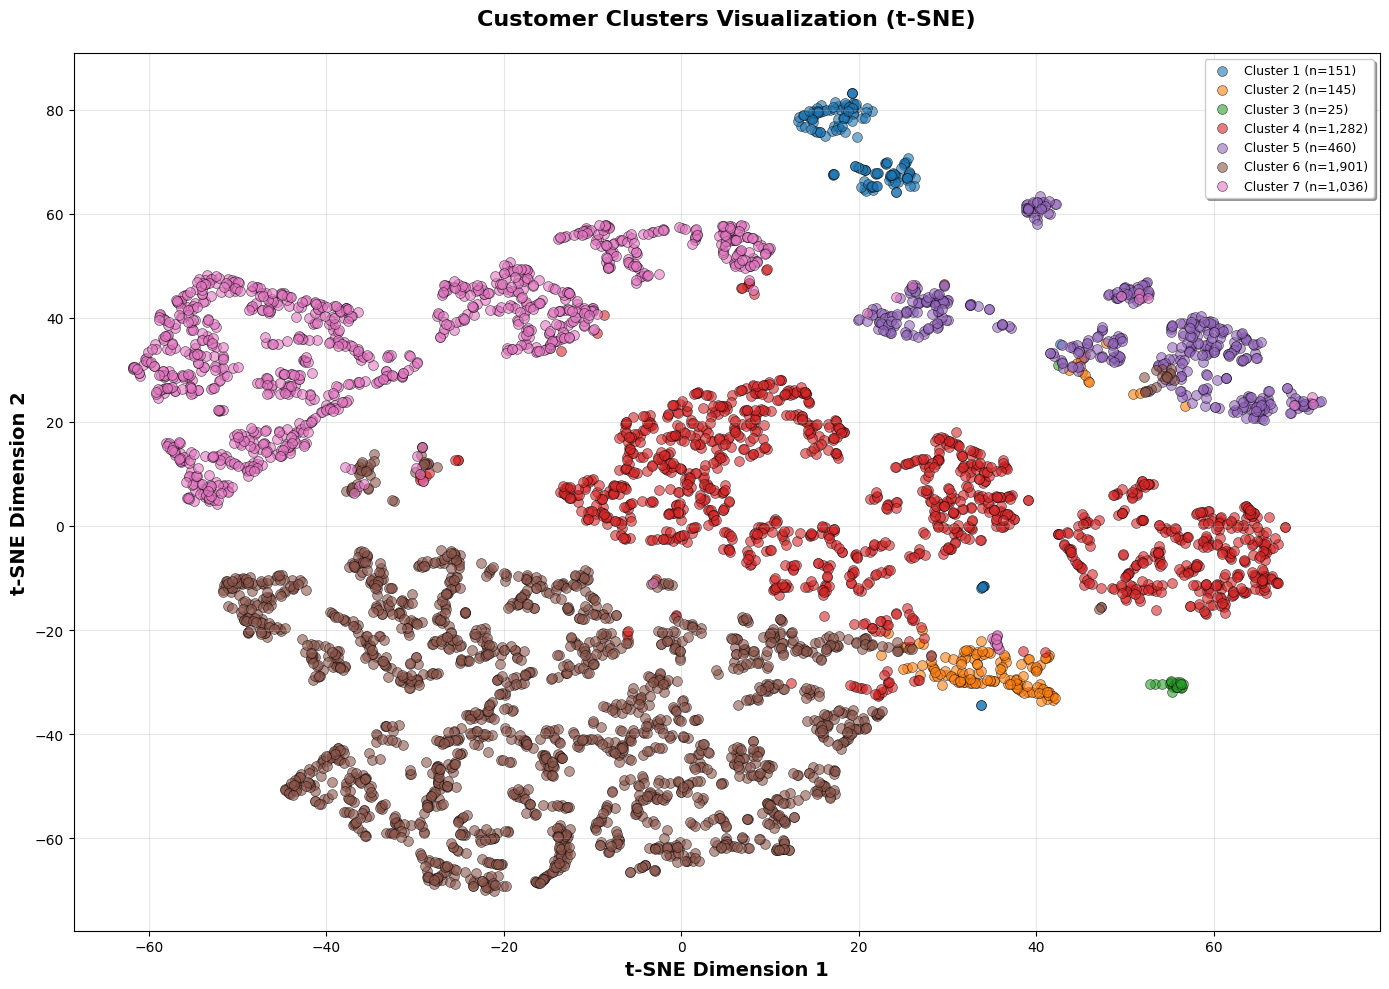


💡 t-SNE 해석:
   - PCA보다 클러스터 분리가 더 명확
   - 거리 자체는 의미 없음 (상대적 위치만 중요)


In [ ]:
# DataFrame으로 변환
tsne_df = pd.DataFrame({
    'Dim1': tsne_result[:, 0],
    'Dim2': tsne_result[:, 1],
    'cluster': tsne_clusters
})

# 시각화
plt.figure(figsize=(14, 10))

clusters = sorted(tsne_df['cluster'].unique())

for idx, cluster_id in enumerate(clusters):
    cluster_data = tsne_df[tsne_df['cluster'] == cluster_id]
    plt.scatter(cluster_data['Dim1'], cluster_data['Dim2'],
                c=[colors[idx]],
                label=f'Cluster {cluster_id} (n={len(cluster_data):,})',
                alpha=0.6,
                s=50,
                edgecolors='black',
                linewidth=0.5)

plt.xlabel('t-SNE Dimension 1', fontsize=14, fontweight='bold')
plt.ylabel('t-SNE Dimension 2', fontsize=14, fontweight='bold')
plt.title('Customer Clusters Visualization (t-SNE)', fontsize=16, fontweight='bold', pad=20)
plt.legend(loc='best', fontsize=9, frameon=True, shadow=True)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 t-SNE 해석:")
print("   - PCA보다 클러스터 분리가 더 명확")
print("   - 거리 자체는 의미 없음 (상대적 위치만 중요)")


방법 3: 3D 시각화 (PCA)

📊 3D PCA 설명력:
   PC1: 23.4%
   PC2: 17.0%
   PC3: 11.7%
   Total: 52.2%


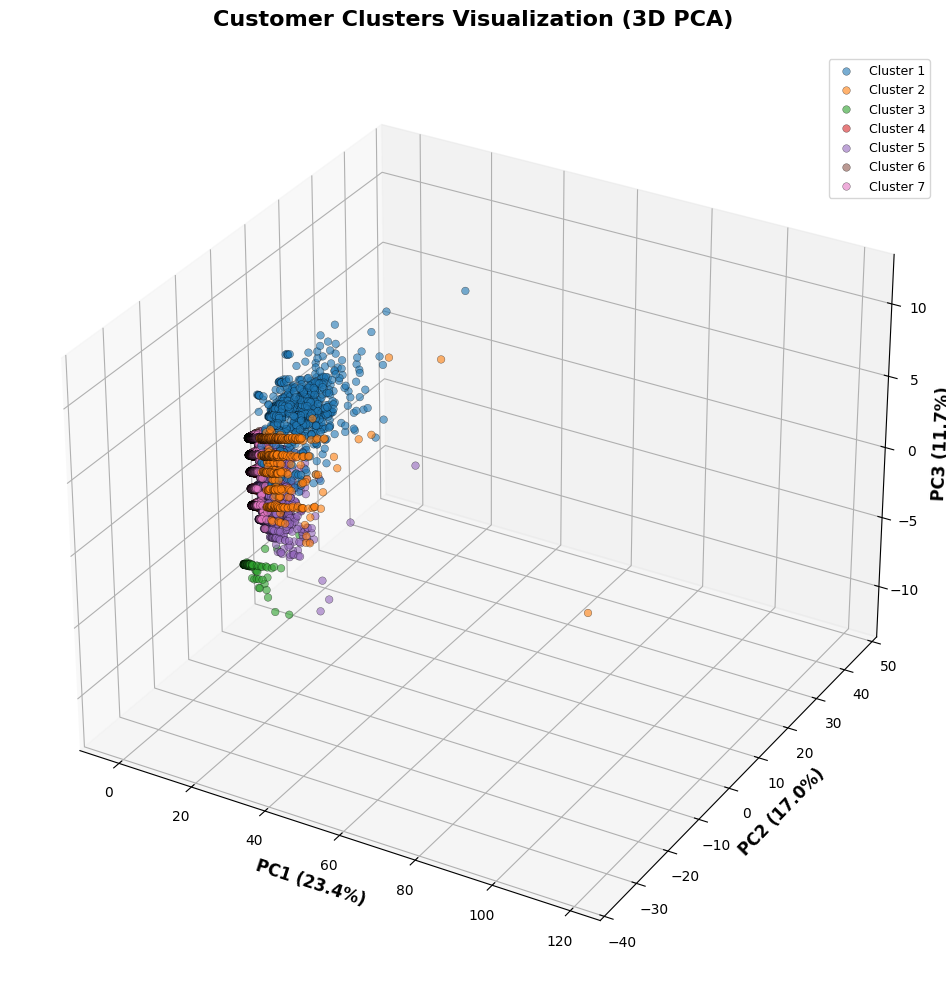

In [ ]:
# --------------------------------------------
# 방법 3: 3D 시각화
# --------------------------------------------

print("\n" + "=" * 60)
print("방법 3: 3D 시각화 (PCA)")
print("=" * 60)

# PCA로 3차원으로 축소
pca_3d = PCA(n_components=3)
pca_3d_result = pca_3d.fit_transform(features_scaled)

print(f"\n📊 3D PCA 설명력:")
print(f"   PC1: {pca_3d.explained_variance_ratio_[0]*100:.1f}%")
print(f"   PC2: {pca_3d.explained_variance_ratio_[1]*100:.1f}%")
print(f"   PC3: {pca_3d.explained_variance_ratio_[2]*100:.1f}%")
print(f"   Total: {sum(pca_3d.explained_variance_ratio_)*100:.1f}%")

# 3D 시각화
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

clusters = sorted(clustered_data['cluster'].unique())

for idx, cluster_id in enumerate(clusters):
    cluster_mask = clustered_data['cluster'] == cluster_id
    ax.scatter(pca_3d_result[cluster_mask, 0],
               pca_3d_result[cluster_mask, 1],
               pca_3d_result[cluster_mask, 2],
               c=[colors[idx]],
               label=f'Cluster {cluster_id}',
               alpha=0.6,
               s=30,
               edgecolors='black',
               linewidth=0.3)

ax.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12, fontweight='bold')
ax.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12, fontweight='bold')
ax.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]*100:.1f}%)', fontsize=12, fontweight='bold')
ax.set_title('Customer Clusters Visualization (3D PCA)', fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=9)
plt.tight_layout()
plt.show()


방법 4: 클러스터 크기 및 특성 비교


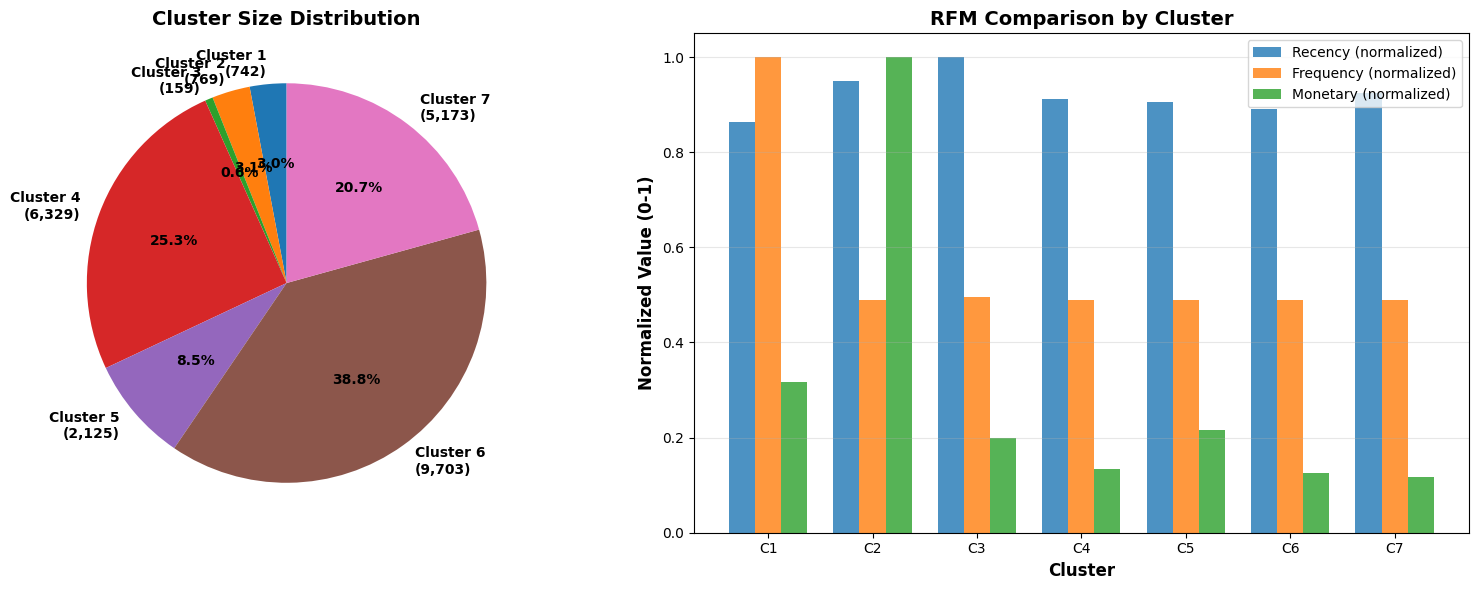


✅ 시각화 완료!


In [ ]:
# --------------------------------------------
# 방법 4: 클러스터 크기 비교
# --------------------------------------------

print("\n" + "=" * 60)
print("방법 4: 클러스터 크기 및 특성 비교")
print("=" * 60)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. 클러스터 크기 비교 (원형 차트)
cluster_counts = clustered_data['cluster'].value_counts().sort_index()
colors_pie = [colors[i] for i in range(len(cluster_counts))]

axes[0].pie(cluster_counts.values,
            labels=[f'Cluster {i}\n({count:,})' for i, count in cluster_counts.items()],
            autopct='%1.1f%%',
            colors=colors_pie,
            startangle=90,
            textprops={'fontsize': 10, 'fontweight': 'bold'})
axes[0].set_title('Cluster Size Distribution', fontsize=14, fontweight='bold')

# 2. 클러스터별 평균 RFM (막대 그래프)
rfm_cols = ['recency', 'frequency', 'monetary']
rfm_cols = [col for col in rfm_cols if col in clustered_data.columns]

if rfm_cols:
    rfm_means = clustered_data.groupby('cluster')[rfm_cols].mean()

    x = np.arange(len(rfm_means))
    width = 0.25

    if 'recency' in rfm_cols:
        axes[1].bar(x - width, rfm_means['recency']/rfm_means['recency'].max(),
                   width, label='Recency (normalized)', alpha=0.8)
    if 'frequency' in rfm_cols:
        axes[1].bar(x, rfm_means['frequency']/rfm_means['frequency'].max(),
                   width, label='Frequency (normalized)', alpha=0.8)
    if 'monetary' in rfm_cols:
        axes[1].bar(x + width, rfm_means['monetary']/rfm_means['monetary'].max(),
                   width, label='Monetary (normalized)', alpha=0.8)

    axes[1].set_xlabel('Cluster', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Normalized Value (0-1)', fontsize=12, fontweight='bold')
    axes[1].set_title('RFM Comparison by Cluster', fontsize=14, fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels([f'C{i}' for i in rfm_means.index])
    axes[1].legend()
    axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("✅ 시각화 완료!")
print("=" * 60)